In [1]:
#imports
from google.colab import drive
from scipy.io import loadmat
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math
import os
import time
import datetime
import itertools
import h5py
import matplotlib.dates as mdates
import random

#paths
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/Stanford-solar-forecasting-dataset/data/"
data_path = data_dir + '2017_2019_images_pv_processed.hdf5'
output_folder = "/content/drive/MyDrive/Stanford-solar-forecasting-dataset/model_output/SUNSET_nowcast+sun_pos_sampi/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import data


In [2]:
#import the test ground truth
times_trainval = np.load(data_dir+"times_trainval.npy", allow_pickle=True)
f = h5py.File(data_dir+'2017_2019_images_pv_processed.hdf5', 'r')
test = f['test']
pv_log = test['pv_log']
images_log = test['images_log']
pv_log = pv_log[:]

### Model architecture

In [3]:
# get the input dimension for constructing the model
img_side_len = test['images_log'].shape[1]
num_color_channel = test['images_log'].shape[3]
image_input_dim = [img_side_len,img_side_len,num_color_channel]
#MYEDIT: getting the dim of the sun_pos
sun_pos_dim = test['sun_pos'].shape[1]
sampi_dim = test['sampi'].shape[1]

print("image side length:", img_side_len)
print("number of color channels:", num_color_channel)
print("input image dimension:", image_input_dim)
#MYEDIT
print("sun_pos dimension:", sun_pos_dim)
print("sampi dimension:", sampi_dim)

# define model characteristics
num_filters = 24
kernel_size = [3,3]
pool_size = [2,2]
strides = 2
dense_size = 1024
drop_rate = 0.4

# define training time parameters
num_epochs = 200 #(The maximum epoches set to 200 and there might be early stopping depends on validation loss)
num_fold = 10 # 10-fold cross-validation
batch_size = 256
learning_rate = 3e-06

image side length: 64
number of color channels: 3
input image dimension: [64, 64, 3]
sun_pos dimension: 2
sampi dimension: 1


In [4]:
# define the model architecture using tf.keras API
def sunset_model():
    ## input
    ### input image logs with shape (64,64,3)
    x_in = keras.Input(shape=image_input_dim)
    ###MYEDIT: input of the sun position with shape (2) and sampi with shape (1)
    x2_in = keras.Input(shape=sun_pos_dim)
    x3_in = keras.Input(shape=sampi_dim)

    ## 1st convolution block
    x = keras.layers.Conv2D(num_filters,kernel_size,padding="same",activation='relu')(x_in)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size, strides)(x)

    ## 2nd convolution block
    x = keras.layers.Conv2D(num_filters*2,kernel_size,padding="same",activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size, strides)(x)

    ## two fully connected nets
    x = keras.layers.Flatten()(x)
    #MYEDIT: concatenating the sun_pos and sampi
    x = keras.layers.Concatenate(axis=1)([x, x2_in, x3_in])

    x = keras.layers.Dense(dense_size, activation='relu')(x)
    x = keras.layers.Dropout(drop_rate)(x)
    x = keras.layers.Dense(dense_size, activation='relu')(x)
    x = keras.layers.Dropout(drop_rate)(x)

    ## regression to prediction target
    y_out = keras.layers.Dense(units=1)(x)

    # construct the model MYEDIT: adding the sun_pos as input
    model = keras.Model(inputs=[x_in, x2_in, x3_in],outputs=y_out)

    return model

# show model architecture
sunset_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 24)   672         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 24)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 24)   0           ['batch_normalization[0][0]']

### Model testing

In [5]:
num_fold = 10 # 10-fold cross-validation

In [6]:
# load testing data
times_test = np.load(os.path.join(data_dir,"times_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(data_path,'r') as f:

    # read in the data
    images_log_test = f['test']['images_log'][...]
    pv_log_test = f['test']['pv_log'][...]
    sun_pos_log_test = f['test']['sun_pos'][...]
    sampi_log_test = f['test']['sampi'][...]

# process image data
images_log_test = (images_log_test/255.0).astype('float32')
pv_log_test = pv_log_test.astype('float32')
sun_pos_log_test = sun_pos_log_test.astype('float32')
sampi_log_test = sampi_log_test.astype('float32')

print("images_log_test.shape:",images_log_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)
print('sun_pos_log_test.shape', sun_pos_log_test.shape)
print('sampi.shape', sampi_log_test.shape)

times_test.shape: (14003,)
images_log_test.shape: (14003, 64, 64, 3)
pv_log_test.shape: (14003,)
sun_pos_log_test.shape (14003, 2)
sampi.shape (14003, 1)


In [7]:
# formulate sunny and cloudy test days
sunny_dates = [(2017,9,15),(2017,10,6),(2017,10,22),
               (2018,2,16),(2018,6,12),(2018,6,23),
               (2019,1,25),(2019,6,23),(2019,7,14),(2019,10,14)]
cloudy_dates = [(2017,6,24),(2017,9,20),(2017,10,11),
                (2018,1,25),(2018,3,9),(2018,10,4),
                (2019,5,27),(2019,6,28),(2019,8,10),(2019,10,19)]

sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

all_dates_test = sunny_dates_test + cloudy_dates_test

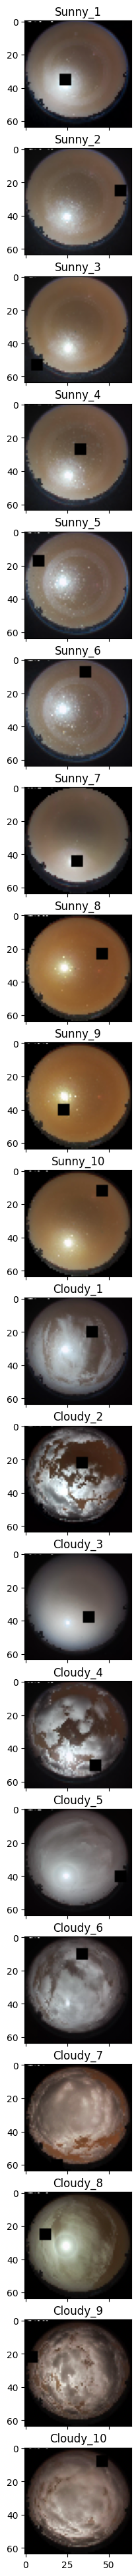

In [8]:
# adding a occl_sizeXoccl_size occlusion (black pixels) randomly in all the test images

occl_size = 7

images_log_test_occlusion = images_log_test.copy()

dates_test = np.asarray([times.date() for times in times_test])

fig,ax = plt.subplots(20,1,sharex=True, sharey = False)
i_sunny = i_cloudy = 1

for i, date in enumerate(all_dates_test):

    date_mask = (dates_test == date)

    rand_x = random.randint(0, img_side_len-5)
    rand_y = random.randint(0, img_side_len-5)


    day_images = images_log_test[date_mask]

    day_images[:, rand_x:rand_x+occl_size, rand_y:rand_y+occl_size, :] = 0

    images_log_test_occlusion[date_mask] = day_images

    ax[i].imshow(day_images[300])
    if date in sunny_dates_test:
      ax[i].set_title('Sunny_'+str(i_sunny))
      i_sunny += 1
    else:
      ax[i].set_title('Cloudy_'+str(i_cloudy))
      i_cloudy += 1

fig.set_size_inches(7,50)
plt.show()

In [9]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=[images_log_test_occlusion, sun_pos_log_test, sampi_log_test], y=pv_log_test, batch_size=200, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict([images_log_test_occlusion, sun_pos_log_test, sampi_log_test], batch_size=200, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_occlusion_'+str(occl_size)+'x'+str(occl_size)+'.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

# loading the baseline prediction ensemble
baseline_test_predictions = np.load(output_folder + "test_predictions.npy", allow_pickle=True)
baseline_prediction_ensemble = np.mean(baseline_test_predictions,axis=0)

loading repetition 1 model ...
evaluating performance for the model
71/71 [==============================] - 39s 543ms/step - loss: 7.8580
generating predictions for the model
71/71 [==============================] - 40s 562ms/step
loading repetition 2 model ...
evaluating performance for the model
71/71 [==============================] - 41s 553ms/step - loss: 7.9856
generating predictions for the model
71/71 [==============================] - 39s 546ms/step
loading repetition 3 model ...
evaluating performance for the model
71/71 [==============================] - 39s 544ms/step - loss: 7.6887
generating predictions for the model
71/71 [==============================] - 39s 542ms/step
loading repetition 4 model ...
evaluating performance for the model
71/71 [==============================] - 40s 555ms/step - loss: 7.5118
generating predictions for the model
71/71 [==============================] - 38s 535ms/step
loading repetition 5 model ...
evaluating performance for the model
71/7

In [10]:
dates_test = np.asarray([times.date() for times in times_test])

## generate mask for the sunny days
mask = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask[np.where(dates_test==i)[0]]=1

## apply the mask to the dataset
times_test_sunny = times_test[mask]
pv_log_test_sunny = pv_log_test[mask]
images_log_test_sunny = images_log_test[mask]
prediction_ensemble_sunny = prediction_ensemble[mask]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask]
pv_log_test_cloudy = pv_log_test[~mask]
images_log_test_cloudy = images_log_test[~mask]
prediction_ensemble_cloudy = prediction_ensemble[~mask]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

times_test_sunny.shape: (6986,)
times_test_cloudy.shape: (7017,)


In [11]:
# RMSE for sunny and cloudy days individually
rmse_sunny = np.sqrt(np.mean(np.square((prediction_ensemble_sunny-pv_log_test_sunny))))
rmse_cloudy = np.sqrt(np.mean(np.square((prediction_ensemble_cloudy-pv_log_test_cloudy))))
rmse_overall = np.sqrt((rmse_sunny**2*len(pv_log_test_sunny)+rmse_cloudy**2*len(pv_log_test_cloudy))/(len(pv_log_test)))

print("test set sunny days RMSE: {0:.3f}".format(rmse_sunny))
print("test set cloudy days RMSE: {0:.3f}".format(rmse_cloudy))
print("test set overall RMSE: {0:.3f}".format(rmse_overall))

test set sunny days RMSE: 1.136
test set cloudy days RMSE: 3.593
test set overall RMSE: 2.667


In [12]:
# MAE for sunny and cloudy days individually
mae_sunny = np.mean(np.abs((prediction_ensemble_sunny-pv_log_test_sunny)))
mae_cloudy = np.mean(np.abs((prediction_ensemble_cloudy-pv_log_test_cloudy)))
mae_overall = (mae_cloudy*len(pv_log_test_cloudy) + mae_sunny*len(pv_log_test_sunny))/(len(pv_log_test))

print("test set sunny days MAE: {0:.3f}".format(mae_sunny))
print("test set cloudy days MAE: {0:.3f}".format(mae_cloudy))
print("test set overall MAE: {0:.3f}".format(mae_overall))

test set sunny days MAE: 0.957
test set cloudy days MAE: 2.625
test set overall MAE: 1.793


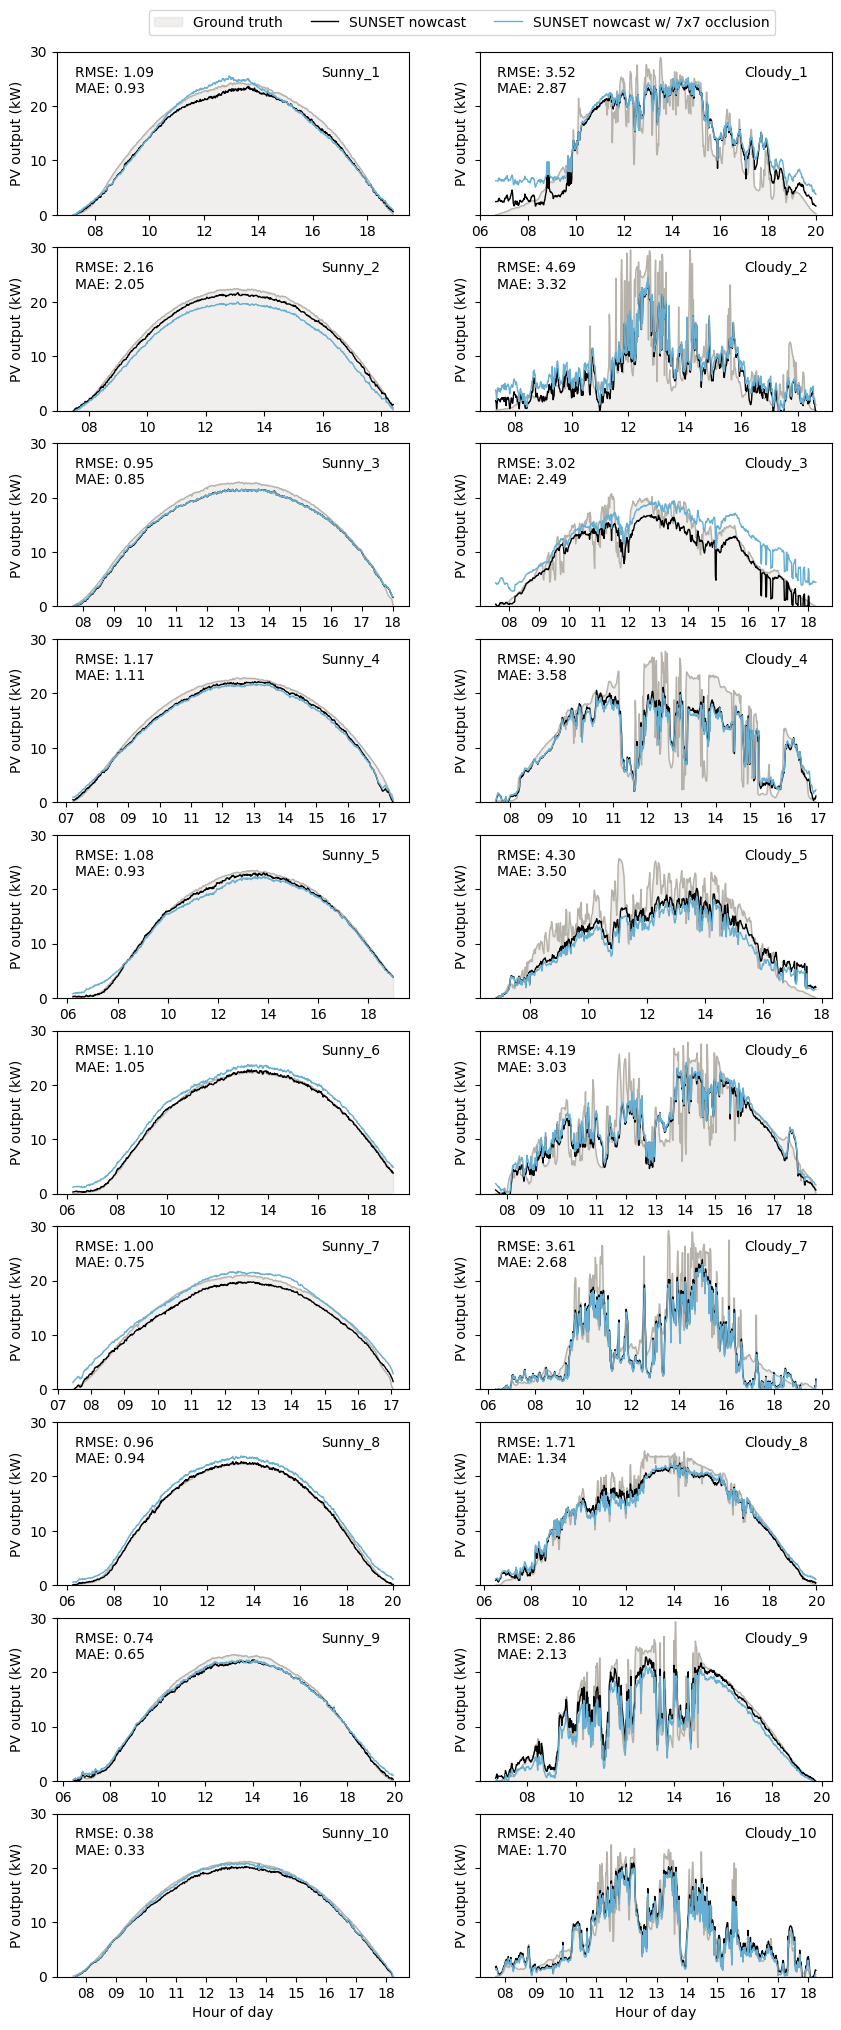

In [13]:
# visualization of nowcast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,2,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#000000'

for i,date in enumerate(sunny_dates_test):
    ax = axarr[i,0]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=grey)
    ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, baseline_prediction_ensemble[date_mask],linewidth = 1,label = 'SUNSET nowcast',color=black,markerfacecolor="None")
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1,label = 'SUNSET nowcast w/ '+str(occl_size)+'x'+str(occl_size)+' occlusion',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75,0.85,'Sunny_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05,0.75,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i,1]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=grey)
    ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, baseline_prediction_ensemble[date_mask],linewidth = 1,label = 'SUNSET nowcast',color=black,markerfacecolor="None")
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1,label = 'SUNSET nowcast w/ '+str(occl_size)+'x'+str(occl_size)+' occlusion',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05,0.75,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)


axarr[0,0].set_ylim(0, 30)
axarr[0,0].legend(bbox_to_anchor= [1.15,1.3], loc = 'upper center', ncol = 3)
axarr[-1,0].set_xlabel('Hour of day')
axarr[-1,1].set_xlabel('Hour of day')

f.set_size_inches(10,25)
plt.show()